## Predictions of Road Accident in Uganda 
> Dataset: uganda_highway_accident_hotspots_2020.kml

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xml.etree import ElementTree as ET
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [10]:
def load_kml(file_path='uganda_highway_accident_hotspots_2020.kml'):
    #Parse KML and extract coordinates
    print("\n[1/4] Loading data...")
    
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
        ns = {'kml': 'http://www.opengis.net/kml/2.2'}
        
        data = []
        for placemark in root.findall('.//kml:Placemark', ns):
            name = placemark.find('kml:name', ns)
            coords = placemark.find('.//kml:coordinates', ns)
            
            if coords is not None and coords.text:
                lon, lat = coords.text.strip().split(',')[:2]
                data.append({
                    'name': name.text if name is not None else 'Unknown',
                    'latitude': float(lat),
                    'longitude': float(lon)
                })
        
        df = pd.DataFrame(data)
        print(f"✓ Loaded {len(df)} locations")
        return df
    
    except:
        print("KML file not found...")

df = load_kml('Uganda_Highway_Accident_hotspots_2020.kml')


[1/4] Loading data...
✓ Loaded 234 locations


## Creating the features

In [11]:
def create_features(df):
    #Simple feature engineering
    print("\n[2/4] Creating features...")
    
    # Distance from Kampala (0.3476°N, 32.5825°E)
    df['dist_kampala'] = np.sqrt((df['latitude'] - 0.3476)**2 + (df['longitude'] - 32.5825)**2) * 111
    
    # Counting nearby hotspots (within 5km)
    df['nearby_count'] = 0
    for i in range(len(df)):
        dist = np.sqrt((df['latitude'] - df.iloc[i]['latitude'])**2 + (df['longitude'] - df.iloc[i]['longitude'])**2) * 111
        df.iloc[i, df.columns.get_loc('nearby_count')] = (dist < 5).sum() - 1
    
    # Creating a risk score (0-100)
    df['risk_score'] = (df['nearby_count'] * 10 + (50 - df['dist_kampala']) * 0.5)  # Closer to Kampala = higher risk
    df['risk_score'] = (df['risk_score'] / df['risk_score'].max()) * 100
    
    # Classifying: Low (0), Medium (1), High (2)
    df['risk_level'] = pd.cut(df['risk_score'], bins=[0, 40, 70, 100], labels=[0, 1, 2])
    
    print(f"Created 4 features")
    print(f"\nRisk Distribution:")
    for i, label in enumerate(['Low', 'Medium', 'High']):
        count = (df['risk_level'] == i).sum()
        print(f" {label}: {count} ({count/len(df)*100:.0f}%)")
    
    return df

df = create_features(df)


[2/4] Creating features...
Created 4 features

Risk Distribution:
 Low: 26 (11%)
 Medium: 7 (3%)
 High: 4 (2%)


## Building a neural network 

In [21]:
class SimpleNN:
    def __init__(self, n_features):
        self.W1 = np.random.randn(n_features, 15) * 0.1
        self.b1 = np.zeros((1, 15))
        self.W2 = np.random.randn(15, 3) * 0.1
        self.b2 = np.zeros((1, 3))
        self.losses = []
    
    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = np.maximum(0, self.z1)  # ReLU
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        exp = np.exp(self.z2 - np.max(self.z2, axis=1, keepdims=True))
        return exp / exp.sum(axis=1, keepdims=True)  # Softmax
    
    def train(self, X, y, epochs=100):
        lr = 0.1
        for epoch in range(epochs):
            # Forward
            output = self.forward(X)
            loss = -np.mean(y * np.log(output + 1e-8))
            self.losses.append(loss)
            
            # Backward
            m = X.shape[0]
            dz2 = (output - y) / m
            dW2 = np.dot(self.a1.T, dz2)
            db2 = np.sum(dz2, axis=0, keepdims=True)
            dz1 = np.dot(dz2, self.W2.T) * (self.z1 > 0)
            dW1 = np.dot(X.T, dz1)
            db1 = np.sum(dz1, axis=0, keepdims=True)
            
            # Update
            self.W1 -= lr * dW1
            self.b1 -= lr * db1
            self.W2 -= lr * dW2
            self.b2 -= lr * db2
            
            if (epoch + 1) % 25 == 0:
                print(f"  Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}")
    
    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

## Model training

In [23]:
def train_model(df):
    print("\n[3/4] Training model...")
    X = df[['dist_kampala', 'nearby_count', 'latitude', 'longitude']].values
    X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)  # Normalizing
    df = df.dropna(subset=['risk_level']).copy() # dropping the NaN values
    df['risk_level'] = df['risk_level'].astype(int)
    y = df['risk_level'].values
    y_onehot = np.eye(3)[y]  # One-hot encode

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_train_oh = np.eye(3)[y_train]

    # Train
    model = SimpleNN(X.shape[1])
    model.train(X_train, y_train_oh, epochs=300)

    # Evaluate
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"Training complete!")
    print(f"\n Test Accuracy: {acc*100:.1f}%")
    return model, X_test, y_test, y_pred

model, X_test, y_test, y_pred = train_model(df)


[3/4] Training model...
  Epoch 25/300 - Loss: 0.2653
  Epoch 50/300 - Loss: 0.2425
  Epoch 75/300 - Loss: 0.2321
  Epoch 100/300 - Loss: 0.2244
  Epoch 125/300 - Loss: 0.2168
  Epoch 150/300 - Loss: 0.2081
  Epoch 175/300 - Loss: 0.1977
  Epoch 200/300 - Loss: 0.1852
  Epoch 225/300 - Loss: 0.1711
  Epoch 250/300 - Loss: 0.1548
  Epoch 275/300 - Loss: 0.1395
  Epoch 300/300 - Loss: 0.1254
Training complete!

 Test Accuracy: 87.5%


## Visualisations


[4/4] Creating visualizations...
Saved as 'uganda_results.png'


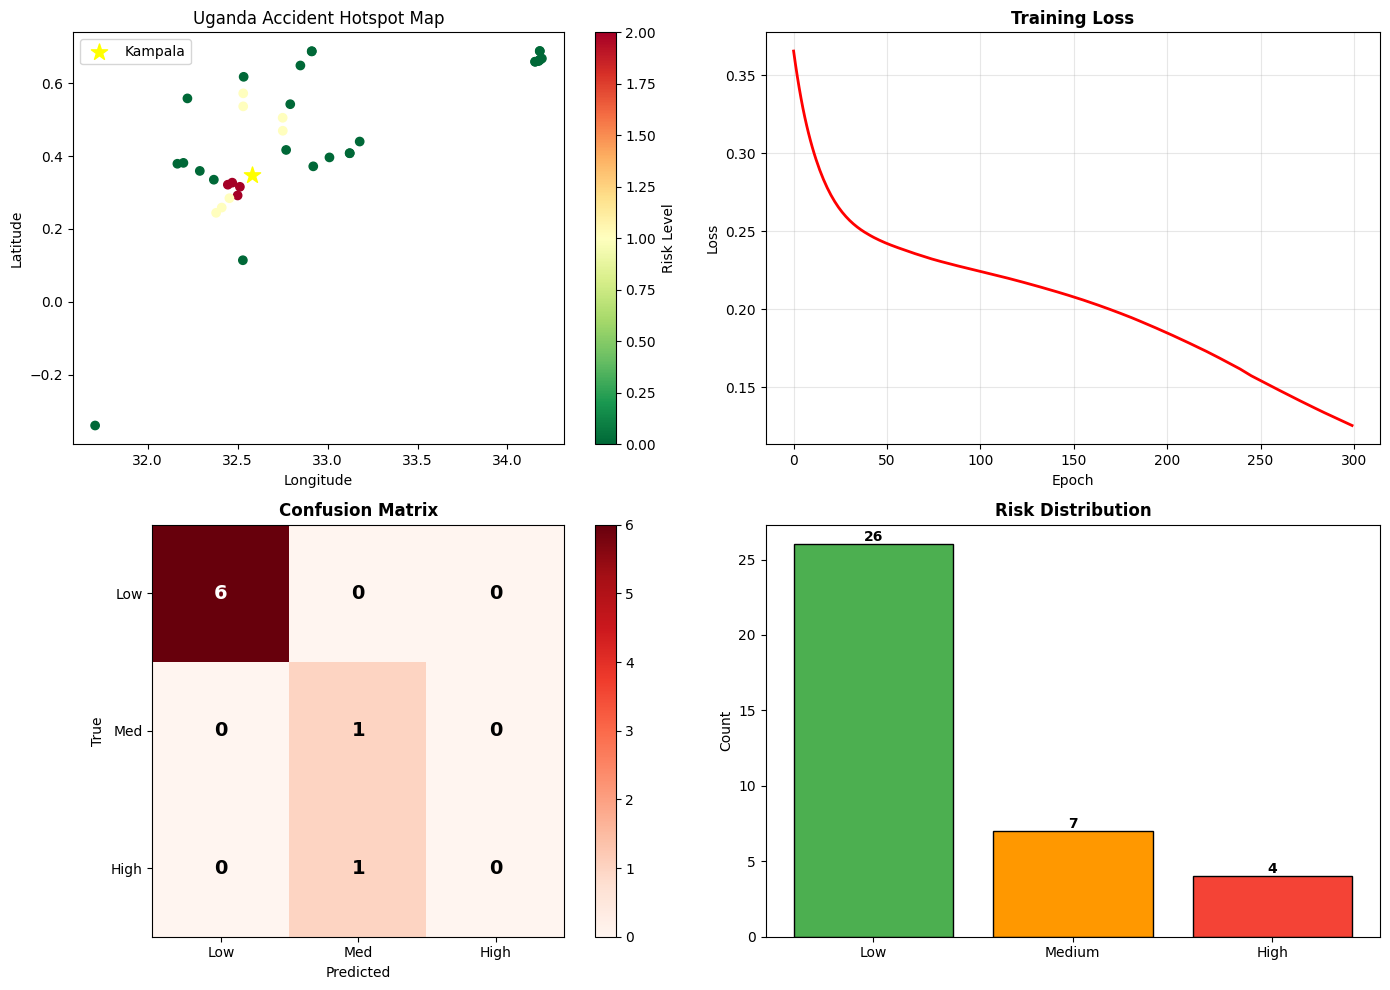

In [24]:
def visualize(model, df, X_test, y_test, y_pred):
    print("\n[4/4] Creating visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Map
    ax = axes[0, 0]
    scatter = ax.scatter(df['longitude'], df['latitude'], c=df['risk_level'].astype(int),cmap='RdYlGn_r')
    ax.scatter(32.5825, 0.3476,color='yellow',s=150,marker='*',label='Kampala')
    ax.set_title("Uganda Accident Hotspot Map")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    plt.colorbar(scatter, ax=ax, label="Risk Level")

    # 2. Loss curve
    ax = axes[0, 1]
    ax.plot(model.losses, color='red', linewidth=2)
    ax.set_title('Training Loss', fontweight='bold', fontsize=12)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.grid(True, alpha=0.3)
    
    # 3. Confusion Matrix
    ax = axes[1, 0]
    cm = confusion_matrix(y_test, y_pred)
    im = ax.imshow(cm, cmap='Reds')
    ax.set_title('Confusion Matrix', fontweight='bold', fontsize=12)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1, 2])
    ax.set_xticklabels(['Low', 'Med', 'High'])
    ax.set_yticklabels(['Low', 'Med', 'High'])
    for i in range(3):
        for j in range(3):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black', fontweight='bold', fontsize=14)
    plt.colorbar(im, ax=ax)
    
    # 4. Risk distribution
    ax = axes[1, 1]
    risk_counts = df['risk_level'].value_counts().sort_index()
    colors = ['#4caf50', '#ff9800', '#f44336']
    bars = ax.bar(['Low', 'Medium', 'High'], risk_counts.values, color=colors, edgecolor='black')
    ax.set_title('Risk Distribution', fontweight='bold', fontsize=12)
    ax.set_ylabel('Count')
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('uganda_results.png', dpi=200, bbox_inches='tight')
    print("Saved as 'uganda_results.png'")
    plt.show()

visualize(model, df, X_test, y_test, y_pred)